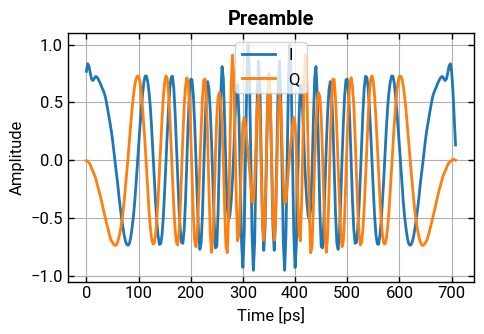

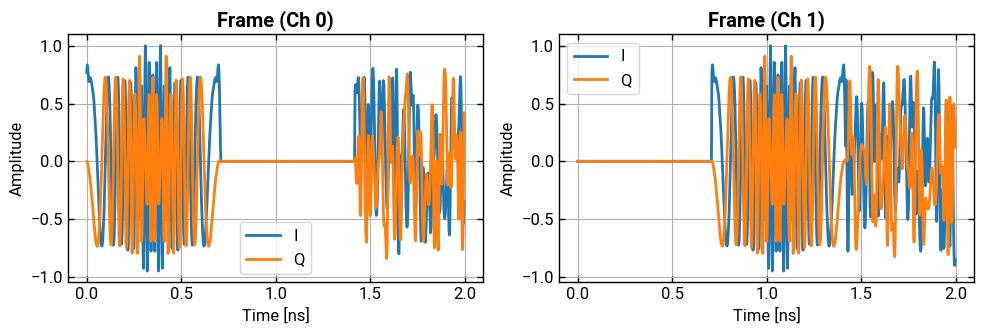

In [87]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("INFO")


symbol_rate = 100e9
sampling_rate = 400e9
sps = int(sampling_rate / symbol_rate)
pilots_mod_scheme = "pam"
pilots_mod_order = 2
payload_mod_scheme = "qam"
payload_mod_order = 32

p = Preamble(sequence_type="zc", length=71)

f = SingleCarrierFrame(
    payload_len=800000,
    payload_seed=42,
    payload_mod_scheme=payload_mod_scheme,
    payload_mod_order=payload_mod_order,
    preamble=p,
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme=pilots_mod_scheme,
    pilot_mod_order=pilots_mod_order,
    pilot_gain_db=0.0,
    num_streams=2,
    preamble_mode="time_orthogonal",
)

ps = p.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
ps.plot_symbols(show=True, title="Preamble")

fs = f.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
fs.plot_symbols(show=True, num_symbols=200, title="Frame")


2026-02-16 17:35:42 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 20.00 dB).
2026-02-16 17:35:42 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


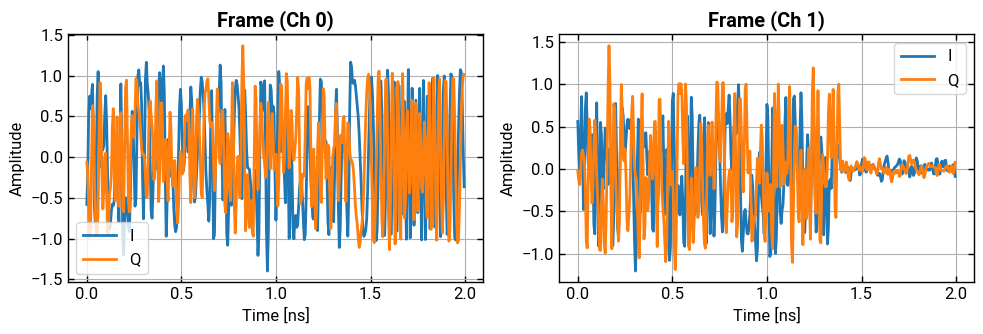

2026-02-16 17:35:42 [INFO] [commstools/sync.py] Channels aligned (spread 0).


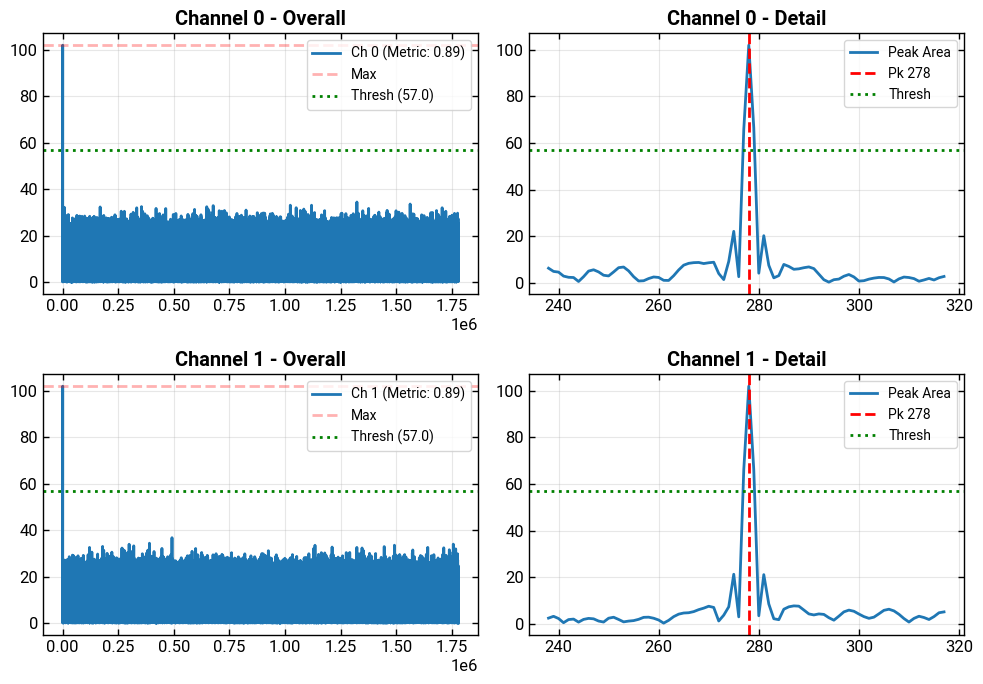

2026-02-16 17:35:43 [INFO] [commstools/sync.py] Frame detected. Starts: [278, 278], Metrics: [0.8936835372579013, 0.8948689060512676]
[278 278]


In [100]:
from commstools.backend import get_array_module
from commstools.impairments import add_awgn
from commstools.sync import detect_frame

rxfs = fs.copy()
xp = get_array_module(rxfs.samples)

rxfs.samples = add_awgn(rxfs.samples, esn0_db=20, sps=rxfs.sps)
rxfs.samples = xp.roll(rxfs.samples, 556, axis=-1)

rxfs.resample(sps_out=2)
rxfs.matched_filter()
rxfs.plot_symbols(show=True, num_symbols=200, title="Frame")

fix = detect_frame(rxfs, p, return_metric=False, debug_plot=True)
print(fix)


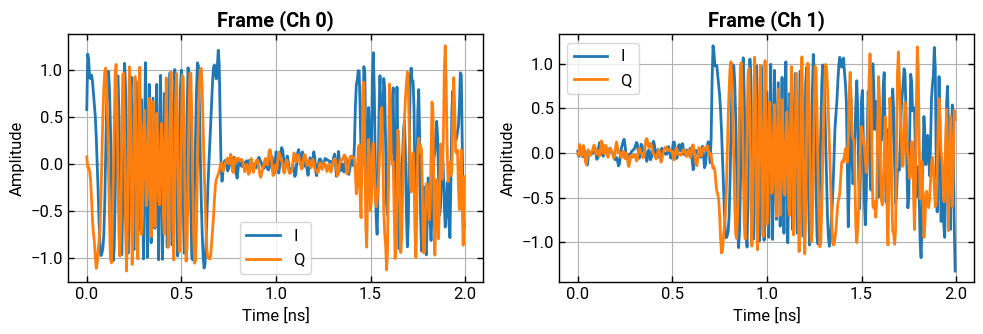

In [101]:
rxfs.samples = xp.roll(rxfs.samples, -fix[0], axis=-1)
rxfs.plot_symbols(show=True, num_symbols=200, title="Frame")


In [102]:
ps = p.to_signal(sps=rxfs.sps, symbol_rate=symbol_rate, pulse_shape="rrc")

rxfs.samples = rxfs.samples[:, 2 * ps.samples.shape[-1] :]


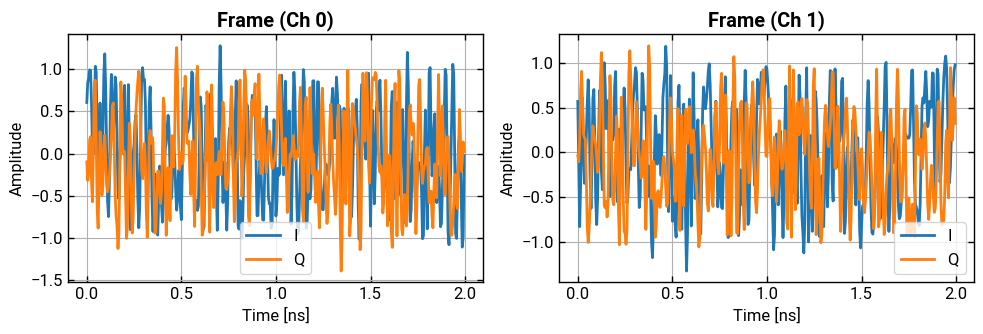

In [103]:
rxfs.plot_symbols(show=True, num_symbols=200, title="Frame")


In [104]:
rxfs.decimate_to_symbol_rate(offset=0)
map = f.get_structure_map(unit="samples", sps=rxfs.sps, include_preamble=False)


In [105]:
pilots = rxfs.copy()
pilots.source_symbols = f.pilot_symbols
pilots.source_bits = f.pilot_bits
pilots.samples = pilots.samples[:, map["pilots"]]

payload = rxfs.copy()
payload.source_symbols = f.payload_symbols
payload.source_bits = f.payload_bits
payload.samples = payload.samples[:, map["payload"]]


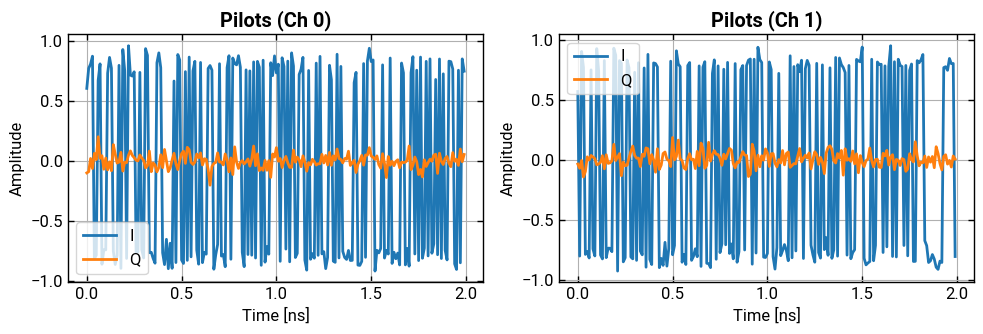

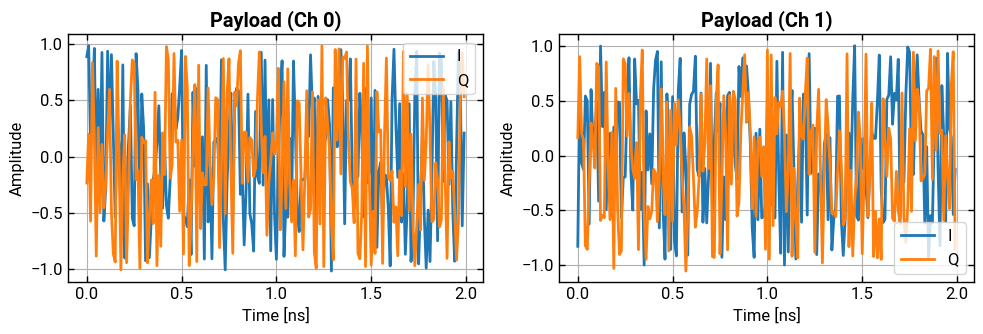

In [106]:
pilots.plot_symbols(show=True, num_symbols=200, title="Pilots")
payload.plot_symbols(show=True, num_symbols=200, title="Payload")


In [107]:
payload.modulation_scheme = payload_mod_scheme
payload.modulation_order = payload_mod_order
pilots.modulation_scheme = pilots_mod_scheme
pilots.modulation_order = pilots_mod_order

payload.resolve_symbols()
pilots.resolve_symbols()
payload.demap_symbols()
pilots.demap_symbols()


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0]], shape=(2, 88889), dtype=int8)

In [108]:
payload.evm()
payload.snr()
payload.ber()


2026-02-16 17:35:43 [INFO] [commstools/metrics.py] EVM Ch0: 9.97% (-20.03 dB)
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] EVM Ch1: 9.99% (-20.01 dB)


2026-02-16 17:35:43 [INFO] [commstools/metrics.py] SNR Ch0: 20.03 dB
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] SNR Ch1: 20.01 dB
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] BER Ch0: 6.60e-04 (2640/4000000 errors)
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] BER Ch1: 7.06e-04 (2826/4000000 errors)


array([0.00066  , 0.0007065])

In [109]:
pilots.evm()
pilots.snr()
pilots.ber()


2026-02-16 17:35:43 [INFO] [commstools/metrics.py] EVM Ch0: 9.99% (-20.01 dB)
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] EVM Ch1: 9.98% (-20.02 dB)
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] SNR Ch0: 20.01 dB
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] SNR Ch1: 20.02 dB
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] BER Ch0: 0.00e+00 (0/88889 errors)
2026-02-16 17:35:43 [INFO] [commstools/metrics.py] BER Ch1: 0.00e+00 (0/88889 errors)


array([0., 0.])

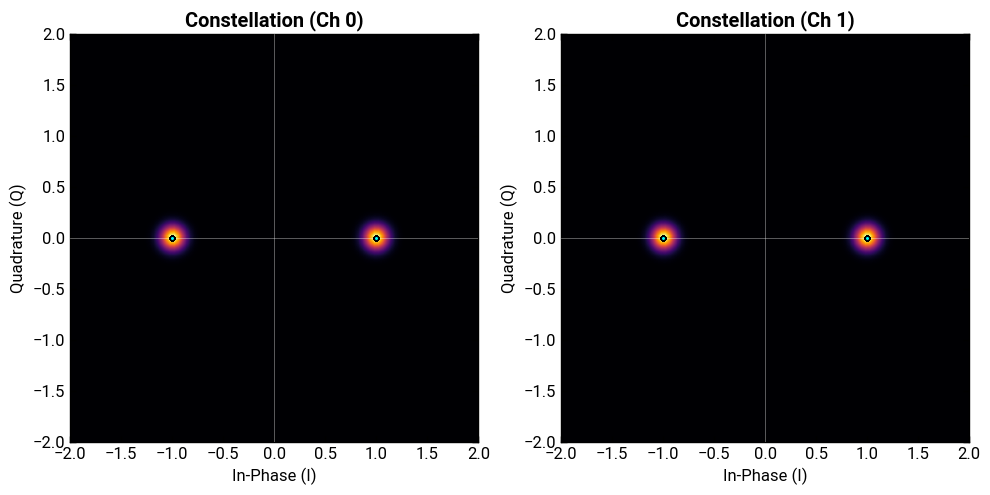

In [110]:
pilots.plot_constellation(data="resolved", overlay_source=True, show=True)


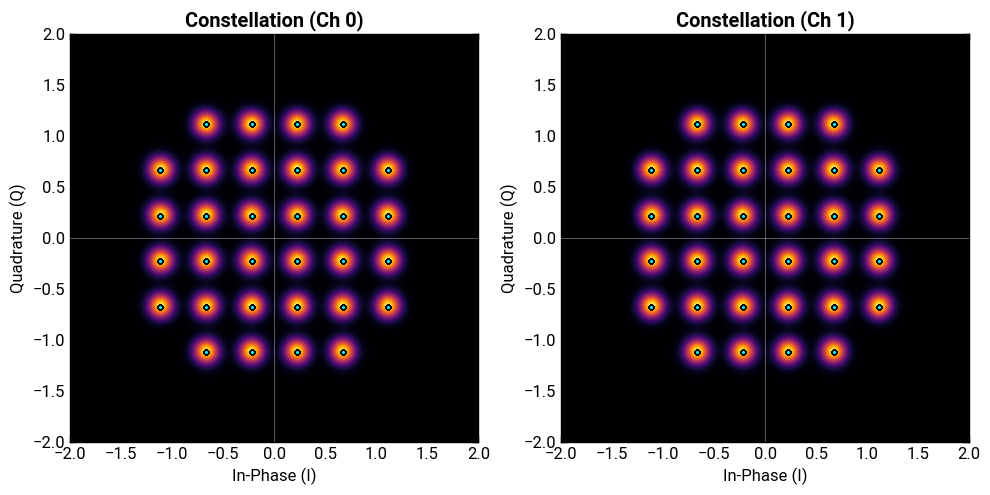

In [111]:
payload.plot_constellation(data="resolved", overlay_source=True, show=True)
